# Usage example and diagnostics of logical failure rate samplers

**Circuits can be defined with the circuit class.**<br>
The Circuit class has a list-like interface (inherited from abstract base class `MutableSequence`) which directly implements list functions like append, insert, len, iter, etc.<br>
A circuit is a list of **circuit ticks** (as in pecos). A tick can be either a list of tuples or a tuple, where a tuple represents one **gate application** and a list of tuples represents parallel gate applications in a tick. One tuple has the structure `(gate, qubits)` where a gate is applied to the specified qubits. For example `('x',3)` or `('cnot', (0,1))` are valid gate applications. Note that for 2-qubit gates the `qubits` attribute is itself a tuple, where the first qubit, `0` in the example, is the control and the second qubit, `1`, is the controlled qubit. The gate symbols are case-insensitive, so `'CNOT'` would also be a valid gate name.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from circuit import Circuit

ghz = Circuit()
ghz.append(('h', 0))
ghz.append(('cnot', (0,1)))
ghz.append(('cnot', (1,2)))
ghz.append(('cnot', (2,3)))
ghz.append(('cnot', (3,4)))
ghz.append(('cnot', (0,4)))
ghz.append(('measure', 4))

print(ghz)

0: ('h', 0)
1: ('cnot', (0, 1))
2: ('cnot', (1, 2))
3: ('cnot', (2, 3))
4: ('cnot', (3, 4))
5: ('cnot', (0, 4))
6: ('measure', 4)


**Define error parameters for circuit level noise**<br>
After we defined our circuit, we want to subject it to circuit level noise by specifying a physical error (i.e. fault) rate (probability) `p_phys` per gate application in the circuit. This is accomplished by iteration over the gates in the circuit and placing a random Pauli error after a gate, if a random uniform variable generated for each gate will be smaller than the given `p_phys`. Note that for 2-qubit gates we can choose from 15 different 2-Pauli errors, while for 1-qubit gates we only have 3 one-qubit Paulis to choose from. If we run such a faulty circuit, there is a chance that the result (determined by a final measurement on specified qubit(s)) will signal a logical error, for example a failed state preparation as in the GHZ preparation circuit which we use here as an example. In this case the measurement outcome on the 5-th qubit (here index 4) will yield +1, which indicates that the prepared state on qubits 1-4 is not the GHZ state. In general, we have to define at some point what measurement outcome of a circuit we want to define as a (logical) error.<br>
Furthermore, we can define error rates for one-qubit and two-qubit gates separately by specifying their rates `p1` and `p2` separately in a dictionary which we pass to the sampler instance we want to create. For now, only one- and two-qubit error rates are implemented, but this can be extended to other gate groups if needed.

In [3]:
import numpy as np

p1 = np.logspace(-3,0,10)
p2 = p1 * 0.5
err_params = {'p1':p1, 'p2':p2}

print(err_params)

{'p1': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]), 'p2': array([0.0005    , 0.00107722, 0.00232079, 0.005     , 0.01077217,
       0.02320794, 0.05      , 0.10772173, 0.23207944, 0.5       ])}


**Run the direct Monte Carlo sampler**<br>
Here, we specified the range of physical error rates for 1-qubit errors, `p1`, we want to inspect and specified that the 2-qubit rates, `p2`, should be half of that. Next, we create a sampler instance and pass our defined `err_params` dictionary and the `ghz` circuit from above to it and start sampling by calling the `run()` method. The `n_samples` parameter gives the amount of samples we want to acquire **per physical error rate** in order to build our estimate of the logical error rate `p_L`.

In [3]:
from sampler import DirectSampler

ds = DirectSampler(ghz, err_params)
ds.__dict__ # defined variables of this sampler

{'circuit': 0: ('h', 0)
 1: ('cnot', (0, 1))
 2: ('cnot', (1, 2))
 3: ('cnot', (2, 3))
 4: ('cnot', (3, 4))
 5: ('cnot', (0, 4))
 6: ('measure', 4),
 'n_qubits': 5,
 'partitions': [[(0, (0,))],
  [(1, (0, 1)), (2, (1, 2)), (3, (2, 3)), (4, (3, 4)), (5, (0, 4))]],
 'p_phys_mat': array([[1.00000000e-03, 5.00000000e-04],
        [2.15443469e-03, 1.07721735e-03],
        [4.64158883e-03, 2.32079442e-03],
        [1.00000000e-02, 5.00000000e-03],
        [2.15443469e-02, 1.07721735e-02],
        [4.64158883e-02, 2.32079442e-02],
        [1.00000000e-01, 5.00000000e-02],
        [2.15443469e-01, 1.07721735e-01],
        [4.64158883e-01, 2.32079442e-01],
        [1.00000000e+00, 5.00000000e-01]]),
 'err_gen': <error_gen.DepolarGen at 0x7fcb6e497760>}

In [10]:
%%time

p_L, std = ds.run(n_samples=5000)

CPU times: user 6.2 s, sys: 9.84 ms, total: 6.21 s
Wall time: 6.14 s


And plot the result:

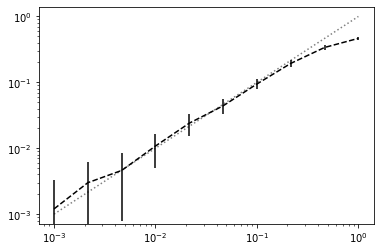

In [11]:
import matplotlib.pyplot as plt

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std)
plt.plot(p1,p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

**Run the subset Monte Carlo sampler**<br>
Using a different sampler is now pretty straight forward by simply instantiating it and running it in the same way. The `SubsetSampler` additionally needs a `p_max` parameter list and a `delta_max` list. These two are used to define the **subset weight cutoff** per defined gate group. The first entry of `p_max`, `p_max[0]` in our example represents the physical error rate at which we tolerate a maximum bounding error `delta_max[0]`, by which a subset weight cutoff for the 1-qubit fault weight subsets is calculated. Similarly for the second entry for the 2-qubit gate group. Note that the `n_samples` parameter here is used independent of the physical error rate `p_phys` for calculating `p_L`, and thus finishes much faster than the direct sampler.

In [5]:
from sampler import SubsetSampler

ss = SubsetSampler(ghz,err_params)
ss.__dict__

{'circuit': 0: ('h', 0)
 1: ('cnot', (0, 1))
 2: ('cnot', (1, 2))
 3: ('cnot', (2, 3))
 4: ('cnot', (3, 4))
 5: ('cnot', (0, 4))
 6: ('measure', 4),
 'n_qubits': 5,
 'partitions': [[(0, (0,))],
  [(1, (0, 1)), (2, (1, 2)), (3, (2, 3)), (4, (3, 4)), (5, (0, 4))]],
 'p_phys_mat': array([[1.00000000e-03, 5.00000000e-04],
        [2.15443469e-03, 1.07721735e-03],
        [4.64158883e-03, 2.32079442e-03],
        [1.00000000e-02, 5.00000000e-03],
        [2.15443469e-02, 1.07721735e-02],
        [4.64158883e-02, 2.32079442e-02],
        [1.00000000e-01, 5.00000000e-02],
        [2.15443469e-01, 1.07721735e-01],
        [4.64158883e-01, 2.32079442e-01],
        [1.00000000e+00, 5.00000000e-01]]),
 'err_gen': <error_gen.DepolarGen at 0x7f209dcbc9d0>}

In [6]:
%%time

p_L_low, p_L_up, ss_std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=5000);

CPU times: user 2.23 s, sys: 9.98 ms, total: 2.24 s
Wall time: 2.19 s


Furthermore, we note that after running this sampler we get back a **lower and upper bound** on the logical error rate instead of a direct estimate. This we can then plot:

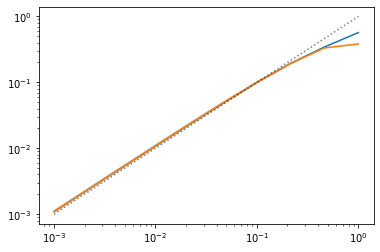

In [7]:
import matplotlib.pyplot as plt

plt.plot(p1, p_L_low, label="SS low")
plt.fill_between(p1, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p1, p_L_up, label="SS up")
plt.fill_between(p1, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)
plt.plot(p1,p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')

By default, the `SubsetSampler` uses a balanced sampling strategy to sample equally from every fault weight subset. To see this we have to dig a bit deeper into the code. Let's redefine the run method to give us the `cnts` and `fail_cnts` 2-d arrays instead of the failure rates and standard deviation. These arrays contain the number of samples the algorithm took in total and the accumulated number of logical failures that were detected per subset.

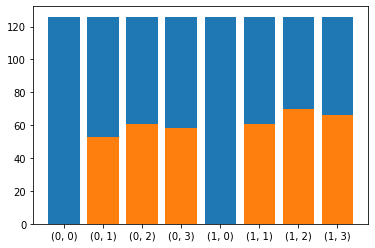

In [26]:
from sampler import SubsetSampler
from calc import balanced_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, balanced_SS_selector)
        return fail_counts, counts, weights
            
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=1000)

x = range(len(counts))
plt.bar(x, counts)
plt.bar(x, fail_counts)
plt.xticks(x, weights);

As we can see, the `balanced_SS_selector` causes the sampler to select from all subsets equally. We can see that the subsets `(x,0)`, where we have no 2-qubit gate errors show no fail counts. This is expected, as the `ghz` circuit contains a single (1-qubit) Hadamard gate and we know that this circuit is fault-tolerant (can with-stand weight-1 faults). Furthermore, we see that the resulting subset error rates for larger weight subsets are slightly higher than for lower ones, as expected, although the overall subset rates look pretty similar about 60/120 ~ 0.5.<br>
Next, we look at the `ERV_SS_selector`.

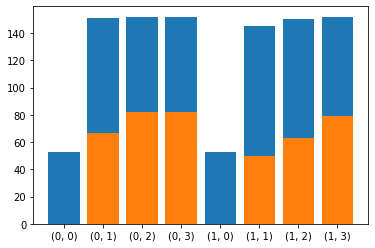

In [27]:
from sampler import SubsetSampler
from calc import ERV_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, ERV_SS_selector)
        return fail_counts, counts, weights
            
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=1000)

x = range(len(counts))
plt.bar(x, counts)
plt.bar(x, fail_counts)
plt.xticks(x, weights);

We clearly see that the unimportant `(0,0)` and `(1,0)` subsets are sampled less often, which is good. We can also see that the other subsets are sampled about equally often. Looking at the error rates this is a bit surprising since we can now see larger differences between them. The reason for this behavior is that the `ERV` criterium takes the binomial weights (probability distribution) of the fault weight subsets in the space of all faulty circuits (distribution of generic errors at any circuit location) into account. Thus, although some subsets that produce large error rates are sampled less often simply because their probability of occurance in the generation of faulty circuits is low in comparison to other subsets.<br>
Let's look at another alternative, the `Metropolis_SS_selector`:

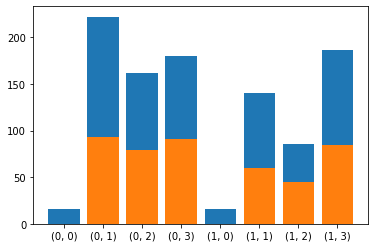

In [28]:
from sampler import SubsetSampler
from calc import Metropolis_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, Metropolis_SS_selector)
        return fail_counts, counts, weights
            
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=1000)

x = range(len(counts))
plt.bar(x, counts)
plt.bar(x, fail_counts)
plt.xticks(x, weights);

Here, we see even clearer that the unimportant subsets are strongly suppressed. Also, the `Metropolis_SS_selector` favors those subsets that generate high subset failure rates much more than the `ERV_SS_selector`, since it uses solely the subset failure rate data without taking the binomial weights into account. This has the advantage of preferrentially sampling in the truely important subsets in terms of failure rates, thus can give same additional information about which subsets are the "most dangerous" ones for a circuit. However, in terms of the logical failure rate `p_L`, these subsets might have only very little impact and thus are unnecessary to sample.<br>
Next, we're going to take a look at how the subset failure rates evolve with each sample for the 3 different selectors:

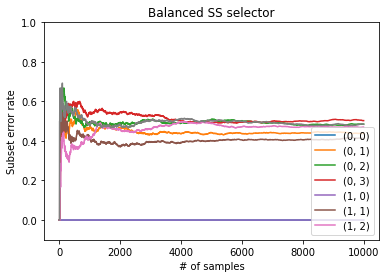

In [62]:
from sampler import SubsetSampler
from calc import balanced_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))
        
        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i])
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, balanced_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=10000)

plt.plot((fail_counts/counts).T);
plt.xlabel('# of samples');
plt.ylabel('Subset error rate');
plt.title('Balanced SS selector');
plt.legend(weights[:-1], loc='lower right');
plt.ylim([-0.1,1]);

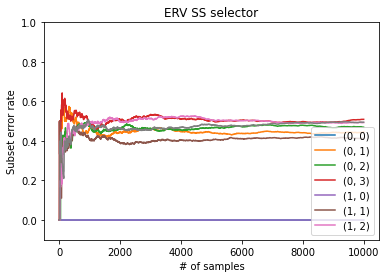

In [63]:
from sampler import SubsetSampler
from calc import ERV_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))
        
        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i])
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, ERV_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=10000)

plt.plot((fail_counts/counts).T);
plt.xlabel('# of samples');
plt.ylabel('Subset error rate');
plt.title('ERV SS selector');
plt.legend(weights[:-1], loc='lower right');
plt.ylim([-0.1,1]);

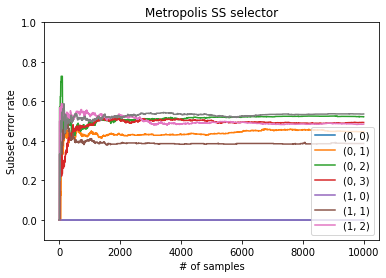

In [65]:
from sampler import SubsetSampler
from calc import Metropolis_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))
        idx = np.random.choice(len(w_vecs)) # For the Metropolis selector we need to give an inital idx.
        
        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i], idx)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, Metropolis_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=10000)

plt.plot((fail_counts/counts).T);
plt.xlabel('# of samples');
plt.ylabel('Subset error rate');
plt.title('Metropolis SS selector');
plt.legend(weights[:-1], loc='lower right');
plt.ylim([-0.1,1]);

It should be noted that in the above plots is relatively large variance, i.e. everytime we repeat these plots we get vastely different results. This can also be shown directly by calculating the evolution of the individual variances for each subset rate and plot them:

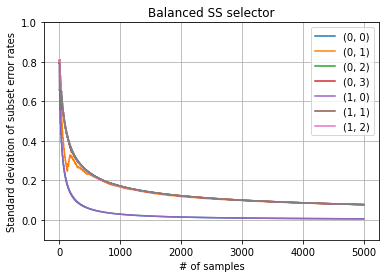

In [80]:
from sampler import SubsetSampler
from calc import balanced_SS_selector, Wilson_std

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i])
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, balanced_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=5000)
pws = fail_counts / counts
std = Wilson_std(pws, counts)

plt.plot(std.T);
plt.xlabel('# of samples');
plt.ylabel('Standard deviation of subset error rates');
plt.title('Balanced SS selector');
plt.legend(weights[:-1], loc='upper right');
plt.ylim([-0.1,1]);
plt.grid();

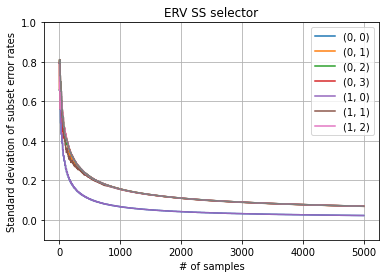

In [79]:
from sampler import SubsetSampler
from calc import ERV_SS_selector, Wilson_std

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i])
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, ERV_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=5000)
pws = fail_counts / counts
std = Wilson_std(pws, counts)

plt.plot(std.T);
plt.xlabel('# of samples');
plt.ylabel('Standard deviation of subset error rates');
plt.title('ERV SS selector');
plt.legend(weights[:-1], loc='upper right');
plt.ylim([-0.1,1]);
plt.grid();

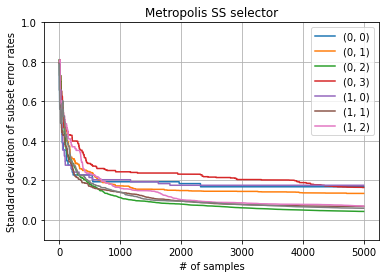

In [81]:
from sampler import SubsetSampler
from calc import Metropolis_SS_selector, Wilson_std

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros((len(w_vecs), n_samples)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros((len(w_vecs), n_samples))
        idx = np.random.choice(len(w_vecs))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts[:,i], fail_cnts[:,i], idx)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx,i:] += self._check_logical_failure(msmt)
            cnts[idx,i:] += 1
        return fail_cnts, cnts
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        fail_counts, counts = self._monte_carlo(weights, n_samples, Metropolis_SS_selector)
        return fail_counts, counts, weights
    
ss = SubsetSamplerDiagnostic(ghz,err_params)
fail_counts, counts, weights = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=5000)
pws = fail_counts / counts
std = Wilson_std(pws, counts)

plt.plot(std.T);
plt.xlabel('# of samples');
plt.ylabel('Standard deviation of subset error rates');
plt.title('Metropolis SS selector');
plt.legend(weights[:-1], loc='upper right');
plt.ylim([-0.1,1]);
plt.grid();

The ERV selector does the best job in reducing the variance of the subset error rates. The Metropolis selector on the other hand performs rather poorly in this regard. If we ignore the `(0,0)` and the `(1,0)` subsets, which have a very high variance due to highly suppressed sampling, also other subsets which are not so actively sampled show large variance in comparison with the other selectors. We have to keep in mind that these plots only consider the pure subset failure rates without their binomial weights and are thus not representative for the true logical failure rate estimator `p_L`. It remains to plot the progression of the `p_L` and its variance (i.e. standard deviation) as a function of samples.

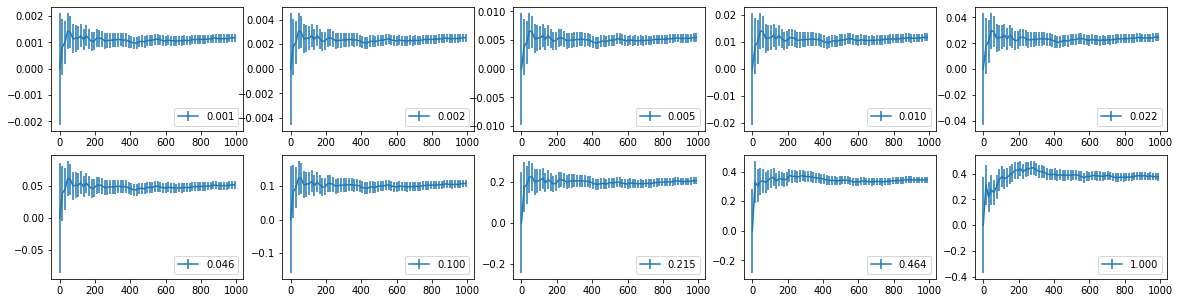

In [72]:
from sampler import SubsetSampler
from calc import balanced_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros(len(w_vecs)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros(len(w_vecs))
        
        Aws = self._calc_binomial_weights(w_vecs)
        ps = self.p_phys_mat.shape[0]
        p_L = np.zeros((n_samples,ps)) # stores lower bounds of the logical error rate as function of samples
        std = np.zeros((n_samples,ps))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts, fail_cnts)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
            
            # calc statistics
            pws = (fail_cnts / cnts)[:,None]
            _, p_L_low, stdev = self._calc_stats(Aws, pws, i+1)
            std[i] = stdev
            p_L[i] = p_L_low
            
        return p_L, std
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        return self._monte_carlo(weights, n_samples, balanced_SS_selector)

n_samples = 1000
ss = SubsetSamplerDiagnostic(ghz,err_params)
p_L, std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=n_samples)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,5))

slicing = 15
for i in range(2):
    for j in range(5):
        ax[i,j].errorbar(np.arange(0,n_samples,slicing), p_L[::slicing,5*i+j], yerr=std[::slicing,5*i+j], label='%.3f' % p1[5*i+j])
        ax[i,j].legend(loc='lower right')
        

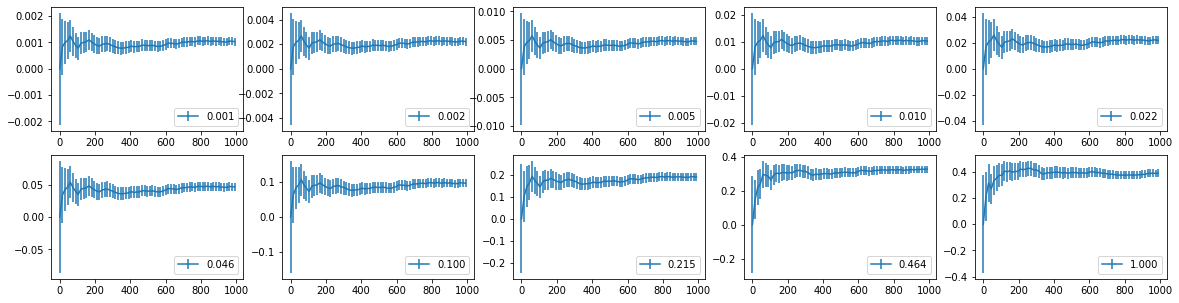

In [73]:
from sampler import SubsetSampler
from calc import ERV_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros(len(w_vecs)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros(len(w_vecs))
        
        Aws = self._calc_binomial_weights(w_vecs)
        ps = self.p_phys_mat.shape[0]
        p_L = np.zeros((n_samples,ps)) # stores lower bounds of the logical error rate as function of samples
        std = np.zeros((n_samples,ps))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts, fail_cnts)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
            
            # calc statistics
            pws = (fail_cnts / cnts)[:,None]
            _, p_L_low, stdev = self._calc_stats(Aws, pws, i+1)
            std[i] = stdev
            p_L[i] = p_L_low
            
        return p_L, std
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        return self._monte_carlo(weights, n_samples, ERV_SS_selector)

n_samples = 1000
ss = SubsetSamplerDiagnostic(ghz,err_params)
p_L, std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=n_samples)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,5))

slicing = 15
for i in range(2):
    for j in range(5):
        ax[i,j].errorbar(np.arange(0,n_samples,slicing), p_L[::slicing,5*i+j], yerr=std[::slicing,5*i+j], label='%.3f' % p1[5*i+j])
        ax[i,j].legend(loc='lower right')

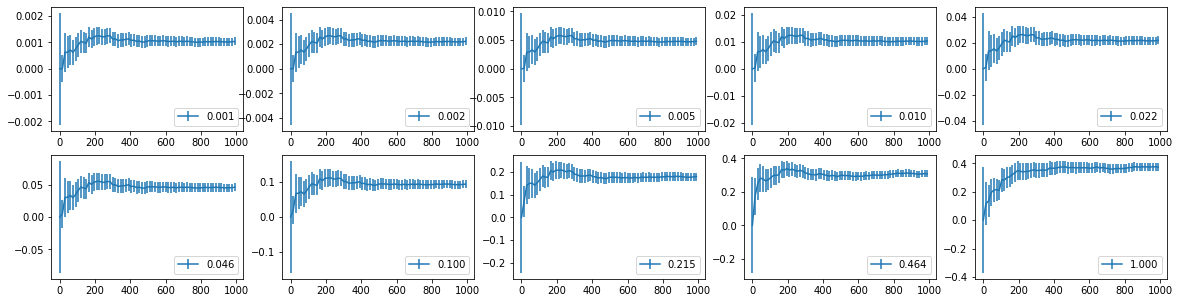

In [74]:
from sampler import SubsetSampler
from calc import Metropolis_SS_selector

class SubsetSamplerDiagnostic(SubsetSampler):
    
    def _monte_carlo(self, w_vecs, n_samples, SS_sel_fn):
        cnts = np.zeros(len(w_vecs)) + 1 # 1 virtual sample to avoid div0 error
        fail_cnts = np.zeros(len(w_vecs))
        
        Aws = self._calc_binomial_weights(w_vecs)
        ps = self.p_phys_mat.shape[0]
        p_L = np.zeros((n_samples,ps)) # stores lower bounds of the logical error rate as function of samples
        std = np.zeros((n_samples,ps))
        idx = np.random.choice(len(w_vecs))

        for i in range(n_samples):
            idx = SS_sel_fn(cnts, fail_cnts, idx)
            w_vec = w_vecs[idx]
            msmt = self._sample(self.err_gen, w_vec)
            fail_cnts[idx] += self._check_logical_failure(msmt)
            cnts[idx] += 1
            
            # calc statistics
            pws = (fail_cnts / cnts)[:,None]
            _, p_L_low, stdev = self._calc_stats(Aws, pws, i+1)
            std[i] = stdev
            p_L[i] = p_L_low
            
        return p_L, std
            
    def run(self, p_max, delta_max, n_samples):
        weights = self._find_weights(p_max, delta_max)
        return self._monte_carlo(weights, n_samples, Metropolis_SS_selector)

n_samples = 1000
ss = SubsetSamplerDiagnostic(ghz,err_params)
p_L, std = ss.run(p_max=[0.5,0.5], delta_max=[0.1,0.5], n_samples=n_samples)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,5))

slicing = 15
for i in range(2):
    for j in range(5):
        ax[i,j].errorbar(np.arange(0,n_samples,slicing), p_L[::slicing,5*i+j], yerr=std[::slicing,5*i+j], label='%.3f' % p1[5*i+j])
        ax[i,j].legend(loc='lower right')